# Transcript Analysis

In [12]:
%load_ext autoreload
%autoreload 2
import os
import re
import sys
import tqdm
import pickle
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def find_transcripts(author_name):
	transcript_dir_path = '_Transcripts'
	for dir in os.listdir(transcript_dir_path):
		# check if dir and if author_name is in dir
		if os.path.isdir(os.path.join(transcript_dir_path, dir)) and author_name in dir:
			print(f'Found {author_name} in {transcript_dir_path}/{dir}.')
			transcript_paths = []
			for file in sorted(os.listdir(os.path.join(transcript_dir_path, dir)), reverse=True):
				transcript_paths.append(os.path.join(transcript_dir_path, dir, file))
			print(f' Found {len(transcript_paths)} transcripts.')
			return transcript_paths
	print(' Transcript Path not Found author:', os.path.join(os.getcwd(), author_name))

def extract_yaml_front_matter(f, transcript_dict):
	# capture all the meta data until the next --- is found
	meta_data = ''
	meta_dict = defaultdict(str)
	for line in f:
		if line == '---\n':
			break
		meta_data += line
	# extract all the information with 'header' : 'value' format
	meta_data = meta_data.split('\n')
	for data in meta_data:
		if data != '':
			header, value = data.split(': ')
			meta_dict[header] = value
	return meta_dict

def read_transcript(transcript_name, transcript_dict):
	with open(transcript_name, 'r') as f:
		print(f'  Reading: {transcript_name}')
		meta_flag = False
		meta_dict = defaultdict(str)
		for line in f:
			# read the .md meta data in YAML Front Matter format --- 
			if line == '---\n' and not meta_flag:
				meta_dict = extract_yaml_front_matter(f, transcript_dict)
				meta_flag = True
			# title is the first line of the transcript, with # at the beginning
			elif line[0] == '#':
				meta_flag = False
				title = line[1:].strip()
			# date is in the second line of the transcript, between [ and ]
			# url is in the second line of the transcript, between ( and )
			elif line[:2] == '**':
				date = re.search(r'\[(.*?)\]', line).group(1)
				# conver date to datetime (December 6, 2023 -> 2023-12-06)
				date = datetime.datetime.strptime(date, '%B %d, %Y').strftime('%Y-%m-%d')
				# add year, month, day to the dict
				year = date[:4]
				month = date[5:7]
				day = date[8:]
				transcript_dict[title]['date'] = date
				transcript_dict[title]['year'] = year
				transcript_dict[title]['month'] = month
				transcript_dict[title]['day'] = day
				transcript_dict[title]['date'] = date
				# convert date to day of the week
				weekday = datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')
				transcript_dict[title]['weekday'] = weekday
				url = re.search(r'\((.*?)\)', line).group(1)
				transcript_dict[title]['url'] = url
			elif not meta_flag:
				# add the line to the transcript (taking out leading * and other formatting including ' and ")
				transcript_dict[title]['transcript'].append(str(line[3:].strip()))
		if len(meta_dict) > 0:
			for key, value in meta_dict.items():
				transcript_dict[title][key] = value
		return transcript_dict

def dict_to_pandas(transcript_dict):
	# initialize the dataframe
	transcript_df = pd.DataFrame()
	for title, content in transcript_dict.items():
		# add the title to the content at the beginning
		content['title'] = title
		transcript_df = pd.concat([transcript_df, pd.DataFrame([content])], ignore_index=True)
	# sort by year, month, day and reset the index
	transcript_df = transcript_df.sort_values(by=['year', 'month', 'day'], ascending=False, ignore_index=True)
	# move Title to the front of the dataframe
	cols = transcript_df.columns.tolist()
	cols = cols[-1:] + cols[:-1]
	transcript_df = transcript_df[cols]
	# transcript_df['Video Views'] = transcript_df['Video Views'].str.replace(',', '').astype(int)
	return transcript_df

def pickle_transcript_df(transcript_df, author_name):
	print(f'Pickling {author_name} transcript_df.')
	dataframe_dir_path = '_Dataframes'
	if not os.path.exists(dataframe_dir_path):
		os.makedirs(dataframe_dir_path)
	transcript_df_name = f'{author_name}_transcript_df.pickle'
	df_path = os.path.join(dataframe_dir_path, transcript_df_name)
	with open(df_path, 'wb') as f:
		pickle.dump(transcript_df, f)
		print(f' Pickled {transcript_df_name} in {dataframe_dir_path}/.')

def dataframe_exists(author_name):
	dataframe_dir_path = '_Dataframes'
	for file in os.listdir(dataframe_dir_path):
		if author_name in file:
			return True
	return False

def main(reload=True, save_df=False):
	# author_name = sys.argv[1]
	author_name = 'New York Times'
	print(f'Searching for {author_name} transcripts...')
	# check if the dataframe exists
	if dataframe_exists(author_name) and not reload:
		print(f'Found: transcript_df already exists.')
		dataframe_dir_path = os.path.join('_Dataframes', f'{author_name}_transcript_df.pickle')
		print(f'  Loading \'{dataframe_dir_path}\'...')
		with open(dataframe_dir_path, 'rb') as f:
			transcript_df = pickle.load(f)
			print(f'  Number of transcripts: {len(transcript_df)}.')
		return transcript_df
	# if the dataframe does not exist, create it by reading the transcripts
	transcripts = find_transcripts(author_name)
	transcript_dict = defaultdict(lambda: defaultdict(list))
	for transcript in transcripts:
		if '.md' in transcript:
			read_transcript(transcript, transcript_dict)
	transcript_df = dict_to_pandas(transcript_dict)
	if save_df:
		pickle_transcript_df(transcript_df, author_name)
	return transcript_df
	
transcript_df = main()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Searching for New York Times transcripts...
Found New York Times in _Transcripts/New York Times Podcasts.
 Found 328 transcripts.
  Reading: _Transcripts\New York Times Podcasts\20240328_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240327_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240326_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240325_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240324_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240322_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240321_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240320_New York Times Podcasts.md
  Reading: _Transcripts\New York Times Podcasts\20240319_New York Times Podcasts.md
  Reading: _Transcripts\Ne

In [14]:
# reverse the order of the x-axis
transcript_df = transcript_df.sort_values(by='date', ascending=True, ignore_index=True)
transcript_df

,title,date,year,month,day,weekday,url,transcript,Date Generated,Transcription Model,Length,Video Keywords,Video Views,Video Rating
0,The Online Search Wars Got Scary. Fast.,2023-02-17,2023,02,17,Friday,https://www.youtube.com/watch?v=Z55QwBPf5uk,"[From the New York Times, I'm Michael Bobauro....","March 31, 2024",whisper medium 20231117,1746s,[],1043,None
1,Why ‘Made in China’ Is Becoming ‘Made in Mexico’,2023-02-21,2023,02,21,Tuesday,https://www.youtube.com/watch?v=eUs1m_wDHIQ,"[From the New York Times, I'm Sabrina Tavernis...","March 31, 2024",whisper medium 20231117,1720s,[],216412,None
2,The Veterans Fighting to Legalize Psychedelics,2023-02-22,2023,02,22,Wednesday,https://www.youtube.com/watch?v=sMrOhXnW_GU,"[From the New York Times, I'm Michael Boboro. ...","March 31, 2024",whisper medium 20231117,1704s,[],279,None
3,A Ruling That Could End the Internet as We Kno...,2023-02-23,2023,02,23,Thursday,https://www.youtube.com/watch?v=savYer-l7zQ,"[From the New York Times, I'm Michael Bobarro....","March 31, 2024",whisper medium 20231117,1684s,[],236,None
4,A Year of War in Ukraine,2023-02-24,2023,02,24,Friday,https://www.youtube.com/watch?v=pHY36oDnhyc,[My name is Igor Lutsenko. I am 44. I am a rec...,"March 31, 2024",whisper medium 20231117,2062s,[],78,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,The Sunday Read: ‘My Goldendoodle Spent a Week...,2024-03-24,2024,03,24,Sunday,https://www.youtube.com/watch?v=3o1XQePIMS4,"[Hey, I'm Sam Apple., I'm a contributor to the...","March 29, 2024",whisper medium 20231117,1299s,[],1985,None
324,A Terrorist Attack in Russia,2024-03-25,2024,03,25,Monday,https://www.youtube.com/watch?v=2prryDGW2GE,"[From the New York Times, I'm Sabrina Tavernis...","March 29, 2024",whisper medium 20231117,1506s,[],7616,None
325,The United States vs. the iPhone,2024-03-26,2024,03,26,Tuesday,https://www.youtube.com/watch?v=T8ptU0-dBMU,"[From the New York Times, I'm Sabrina Tavernis...","March 29, 2024",whisper medium 20231117,1669s,[],5831,None
326,Democrats’ Plan to Save the Republican House S...,2024-03-27,2024,03,27,Wednesday,https://www.youtube.com/watch?v=PaEBkNA-95c,"[From New York Times, I'm Michael Boborjo., Th...","March 29, 2024",whisper medium 20231117,1619s,[],7813,None


In [24]:
from utils import fuzzy_lookup

def check_for_fuzzy_columns(transcript_df, target_word_list):
	filtered_target_word_list = []
	exclusion_list = []
	for word in target_word_list:
		if f'max_fuzzy_{word}' in transcript_df.columns:
			exclusion_list.append(word)
			# remove the word from the target_word_list
		else:
			filtered_target_word_list.append(word)
	print(f'Excluding the following words already in the dataset: ')
	print(f'  {exclusion_list}')
	return filtered_target_word_list

def topic_search(transcript_df, target_word_list, fuzzy_threshold):
	print('Performing fuzzy search for the following words:')
	print(f'  {target_word_list}')
	# check to see if the target words are already in the transcript_df
	target_word_list_filtered = check_for_fuzzy_columns(transcript_df, target_word_list)
	max_fuzzy_list = defaultdict(list)
	max_fuzzy_word_list = defaultdict(list)

	for idx, transcript in enumerate(transcript_df['transcript']):
		pod_title = transcript_df.iloc[idx]['title']	
		pod_date = transcript_df.iloc[idx]['year'] + '-' + transcript_df.iloc[idx]['month'] + '-' + transcript_df.iloc[idx]['day']
		print(f'{pod_date}: {pod_title}')
		for t_index, target_word in enumerate(target_word_list_filtered):
			max_fuzzy, max_fuzzy_word = fuzzy_lookup.fuzzy_matching(target_word, transcript, fuzzy_threshold)
			max_fuzzy_list[target_word].append(max_fuzzy)
			max_fuzzy_word_list[target_word].append(max_fuzzy_word)
	# add the max_fuzzy and max_fuzzy_word to the transcript_df
	for key in max_fuzzy_list.keys():
		transcript_df[f'max_fuzzy_{key}'] = max_fuzzy_list[key]
		transcript_df[f'max_fuzzy_word_{key}'] = max_fuzzy_word_list[key]
	return transcript_df

# perform fuzzy match for all words in target_word_list
target_word_list = ['Michael Barbaro', 'Sabrina Tavernisi', 'Israel', 'Donald Trump', 'Joe Biden']
fuzzy_threshold = 0.85
transcript_df = topic_search(transcript_df, target_word_list, fuzzy_threshold)


Performing fuzzy search for the following words:
  ['Michael Barbaro', 'Sabrina Tavernisi', 'Israel', 'Donald Trump', 'Joe Biden']
Excluding the following words already in the dataset: 
  ['Michael Barbaro']
2023-02-17: The Online Search Wars Got Scary. Fast.
  Searching for: 0 | Sabrina Tavernisi
  "Sabrina Tavernisi" Match Score: 0.5882 | Match: boring Valentines
  Searching for: 1 | Israel
  "Israel" Match Score: 0.6667 | Match: itself
  Searching for: 2 | Donald Trump
  "Donald Trump" Match Score: 0.5926 | Match: President Trump
  Searching for: 3 | Joe Biden
  "Joe Biden" Match Score: 0.6667 | Match: But Biden
2023-02-21: Why ‘Made in China’ Is Becoming ‘Made in Mexico’
  Searching for: 0 | Sabrina Tavernisi
  "Sabrina Tavernisi" Match Score: 1.0    | Match: Sabrina Tavernisi
  Searching for: 1 | Israel
  "Israel" Match Score: 0.6667 | Match: itself
  Searching for: 2 | Donald Trump
  "Donald Trump" Match Score: 0.5926 | Match: President Trump
  Searching for: 3 | Joe Biden
  "Joe

In [25]:
# pickle the transcript_df
pickle_transcript_df(transcript_df, author_name = 'New York Times')
transcript_df

Pickling New York Times transcript_df.
 Pickled New York Times_transcript_df.pickle in _Dataframes/.


,title,date,year,month,day,weekday,url,transcript,Date Generated,Transcription Model,...,max_fuzzy_Michael Barbaro,max_fuzzy_word_Michael Barbaro,max_fuzzy_Sabrina Tavernisi,max_fuzzy_word_Sabrina Tavernisi,max_fuzzy_Israel,max_fuzzy_word_Israel,max_fuzzy_Donald Trump,max_fuzzy_word_Donald Trump,max_fuzzy_Joe Biden,max_fuzzy_word_Joe Biden
0,The Online Search Wars Got Scary. Fast.,2023-02-17,2023,02,17,Friday,https://www.youtube.com/watch?v=Z55QwBPf5uk,"[From the New York Times, I'm Michael Bobauro....","March 31, 2024",whisper medium 20231117,...,0.689655,Michael Benoit,0.588235,boring Valentines,0.666667,itself,0.592593,President Trump,0.666667,But Biden
1,Why ‘Made in China’ Is Becoming ‘Made in Mexico’,2023-02-21,2023,02,21,Tuesday,https://www.youtube.com/watch?v=eUs1m_wDHIQ,"[From the New York Times, I'm Sabrina Tavernis...","March 31, 2024",whisper medium 20231117,...,0.538462,made across,1.000000,Sabrina Tavernisi,0.666667,itself,0.592593,President Trump,1.000000,Joe Biden
2,The Veterans Fighting to Legalize Psychedelics,2023-02-22,2023,02,22,Wednesday,https://www.youtube.com/watch?v=sMrOhXnW_GU,"[From the New York Times, I'm Michael Boboro. ...","March 31, 2024",whisper medium 20231117,...,0.827586,Michael Boboro,0.571429,Arizona and,0.615385,Michael,0.608696,local strip,0.823529,to Biden
3,A Ruling That Could End the Internet as We Kno...,2023-02-23,2023,02,23,Thursday,https://www.youtube.com/watch?v=savYer-l7zQ,"[From the New York Times, I'm Michael Bobarro....","March 31, 2024",whisper medium 20231117,...,1.000000,Michael Barbaro,0.560000,in Paris,0.923077,Israeli,0.583333,doesnt alter,0.777778,the Biden
4,A Year of War in Ukraine,2023-02-24,2023,02,24,Friday,https://www.youtube.com/watch?v=pHY36oDnhyc,[My name is Igor Lutsenko. I am 44. I am a rec...,"March 31, 2024",whisper medium 20231117,...,0.560000,much about,1.000000,Sabrina Tavernisi,0.666667,Ira,0.555556,on top,0.631579,youve been
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,The Sunday Read: ‘My Goldendoodle Spent a Week...,2024-03-24,2024,03,24,Sunday,https://www.youtube.com/watch?v=3o1XQePIMS4,"[Hey, I'm Sam Apple., I'm a contributor to the...","March 29, 2024",whisper medium 20231117,...,0.551724,Michael Hughes,0.611111,Carolina University,0.666667,Serpel,0.666667,road trip,0.625000,love in
324,A Terrorist Attack in Russia,2024-03-25,2024,03,25,Monday,https://www.youtube.com/watch?v=2prryDGW2GE,"[From the New York Times, I'm Sabrina Tavernis...","March 29, 2024",whisper medium 20231117,...,0.560000,much about,1.000000,Sabrina Tavernisi,0.666667,Visual,0.555556,end up,0.625000,gone in
325,The United States vs. the iPhone,2024-03-26,2024,03,26,Tuesday,https://www.youtube.com/watch?v=T8ptU0-dBMU,"[From the New York Times, I'm Sabrina Tavernis...","March 29, 2024",whisper medium 20231117,...,0.560000,have about,1.000000,Sabrina Tavernisi,0.923077,Israels,1.000000,Donald Trump,0.705882,one idea
326,Democrats’ Plan to Save the Republican House S...,2024-03-27,2024,03,27,Wednesday,https://www.youtube.com/watch?v=PaEBkNA-95c,"[From New York Times, I'm Michael Boborjo., Th...","March 29, 2024",whisper medium 20231117,...,0.750000,Michael a,0.600000,starting this,0.666667,fiscal,0.555556,end up,0.666667,major bridge


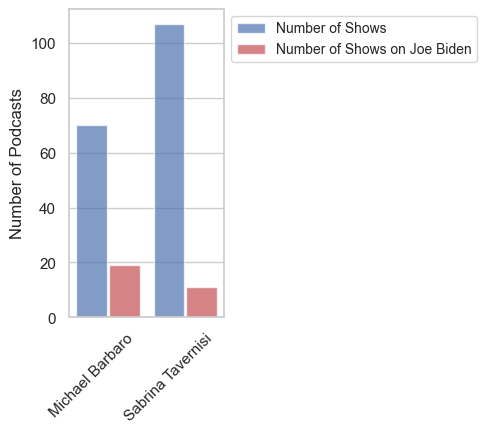

In [28]:
# make a grouped bar plot for the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
# and the number of rows with the topic word with max_fuzzy > 0.9
# make a plot as to the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
sns.set_theme(style="whitegrid")
plt.figure(figsize=(2, 4))
hosts = target_word_list[:2]
topic = target_word_list[4]
# for each host find the number of rows with max_fuzzy > 0.9 and plot
for h_idx, host in enumerate(hosts):
	spacing = 0
	if h_idx > 0:
		spacing = 1
	# find the number of rows with max_fuzzy > 0.9 for the host
	host_df = transcript_df[transcript_df[f'max_fuzzy_{host}'] > 0.85]
	# find the number of rows with max_fuzzy > 0.9 for the topic
	topic_df = host_df[host_df[f'max_fuzzy_{topic}'] > 0.85]
	num_shows = host_df.shape[0]
	num_shows_topic = topic_df.shape[0]
	# plot as double bar graph with host and topic
	if h_idx == 0:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7, label='Number of Shows')
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7, label=f'Number of Shows on {topic}')
	else:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7)
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7)
plt.xticks([0, 2], hosts)
# rotate the x-axis labels
plt.xticks(rotation=45)
# legend outside of box outer right and smaller font size using bbox_to_anchor
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.ylabel('Number of Podcasts')
# only keep horizontal grid
plt.grid(axis='x')